# Conociendo la Base de Validation

Cargamos las bases de datos de test para conocer su estructura y contenido. Realizar un análisis exploratorio de datos (EDA) para identificar patrones, valores faltantes y posibles problemas de calidad de datos.

In [1]:
# Cargamos las bases de datos de train
import pandas as pd
validation_labels = pd.read_csv('../data/raw/validation/validation_labels.csv')
validation_specifications = pd.read_csv('../data/raw/validation/validation_specifications.csv')
validation_operational_readouts = pd.read_csv('../data/raw/validation/validation_operational_readouts.csv')

### Validation Operational Readouts

En general esta base tiene la misma estructura que la de train excepto por el echo de que en esta la data esta incompleta. Aqui solo se incluye un subconjunto de observaciones por vehiculo que llega hasta un readout elegido aleatoriamente. Es decir, no se muestra toda la vida util del vehiculo, sino solo hasta cierto punto.

La idea de esta base es poder simular un escenario de prediccion en tiempo real, donde no se tiene toda la informacion del vehiculo, sino solo hasta cierto punto en el tiempo.

Por ejemplo se puede graficar una distribucion en el tiempo en donde hasta un punto se tiene data y lo que sigue despues de ese punto es mera prediccion.

In [4]:
# visualizar datos
validation_operational_readouts.head()

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,10,3.0,46590.0,3696.0,2038959.0,1450.0,0.0,273826.0,339584.0,99834.0,...,100725.0,8026.0,855.0,15.0,495.0,91665.0,169125.0,51900.0,9362.0,0.0
1,10,7.4,127110.0,16716.0,6501456.0,4660.0,0.0,635642.0,609742.0,288036.0,...,295291.0,44312.0,7995.0,75.0,2265.0,414180.0,688891.0,258810.0,63167.0,1005.0
2,10,8.0,144015.0,19596.0,7327918.0,5230.0,0.0,654780.0,665756.0,300174.0,...,335479.0,52203.0,9421.0,75.0,2415.0,487080.0,812071.0,300735.0,77477.0,1500.0
3,10,12.0,187560.0,24264.0,9286082.0,7420.0,2647.0,831628.0,794332.0,360066.0,...,463265.0,61399.0,10727.0,75.0,2610.0,655620.0,1118116.0,403516.0,99587.0,1591.0
4,10,12.2,187575.0,24264.0,9286082.0,7420.0,NaN,NaN,NaN,NaN,...,463265.0,61400.0,10727.0,75.0,2611.0,655620.0,1118116.0,403517.0,99588.0,1592.0


In [6]:
# verificamos que si incluya la misma cantidad de vehiculos que en train
validation_operational_readouts['vehicle_id'].nunique()

5046

Aqui tambien se trabaja por variables y bins de cada variable, al igual que en train.

In [13]:
# vamos a sacar las bins por variable
sensor_bins_columns = validation_operational_readouts.columns.difference(['vehicle_id', 'time_step']).tolist()
sensor_bins_dict = {}

for col in sensor_bins_columns:
    sensor_id = col.split('_')[0]  # extraemos el sensor id
    if sensor_id not in sensor_bins_dict:
        sensor_bins_dict[sensor_id] = 0
    sensor_bins_dict[sensor_id] += 1

#imprimimos el diccionario de bins por variable
for sensor_id, bin_count in sensor_bins_dict.items():
    print(f"Sensor {sensor_id}: Tiene {bin_count} bins")


Sensor 100: Tiene 1 bins
Sensor 158: Tiene 10 bins
Sensor 167: Tiene 10 bins
Sensor 171: Tiene 1 bins
Sensor 272: Tiene 10 bins
Sensor 291: Tiene 11 bins
Sensor 309: Tiene 1 bins
Sensor 370: Tiene 1 bins
Sensor 397: Tiene 36 bins
Sensor 427: Tiene 1 bins
Sensor 459: Tiene 20 bins
Sensor 666: Tiene 1 bins
Sensor 835: Tiene 1 bins
Sensor 837: Tiene 1 bins


Aqui nos damos cuenta que es identica a la de train en cuanto a cantidad de sensores con sus bins. 

In [14]:
# si contiene valores nulos pero es muy pequeña esa cantidad
validation_operational_readouts.isnull().sum().sum()

np.int64(60339)

In [15]:
# la cantidad con respecto al total de datos es muy pequeña
total_values = validation_operational_readouts.size
null_values = validation_operational_readouts.isnull().sum().sum()
null_percentage = (null_values / total_values) * 100
print(f"Porcentaje de valores nulos: {null_percentage:.6f}%")

Porcentaje de valores nulos: 0.287379%


El porcentaje total no llega ni al 1% de valores nulos. por tanto teniendo en cuenta que es una base de validacion, no se haran imputaciones y se dejara asi como esta.

In [16]:
# vamos a guardar las bases limpias
validation_operational_readouts.to_csv('../data/processed/validation/validation_operational_readouts_clean.csv', index=False)

Vamos a hacer una comparacion entre la base de train y validation para ver si tienen la misma distribucion en las variables principales. Esto es importante para asegurar que el modelo entrenado en la base de train pueda generalizar bien en la base de validation.

In [34]:
#cargamos la base de train limpia para comparacion
train_operational_readouts = pd.read_csv('../data/processed/train/train_operational_readouts_clean.csv')

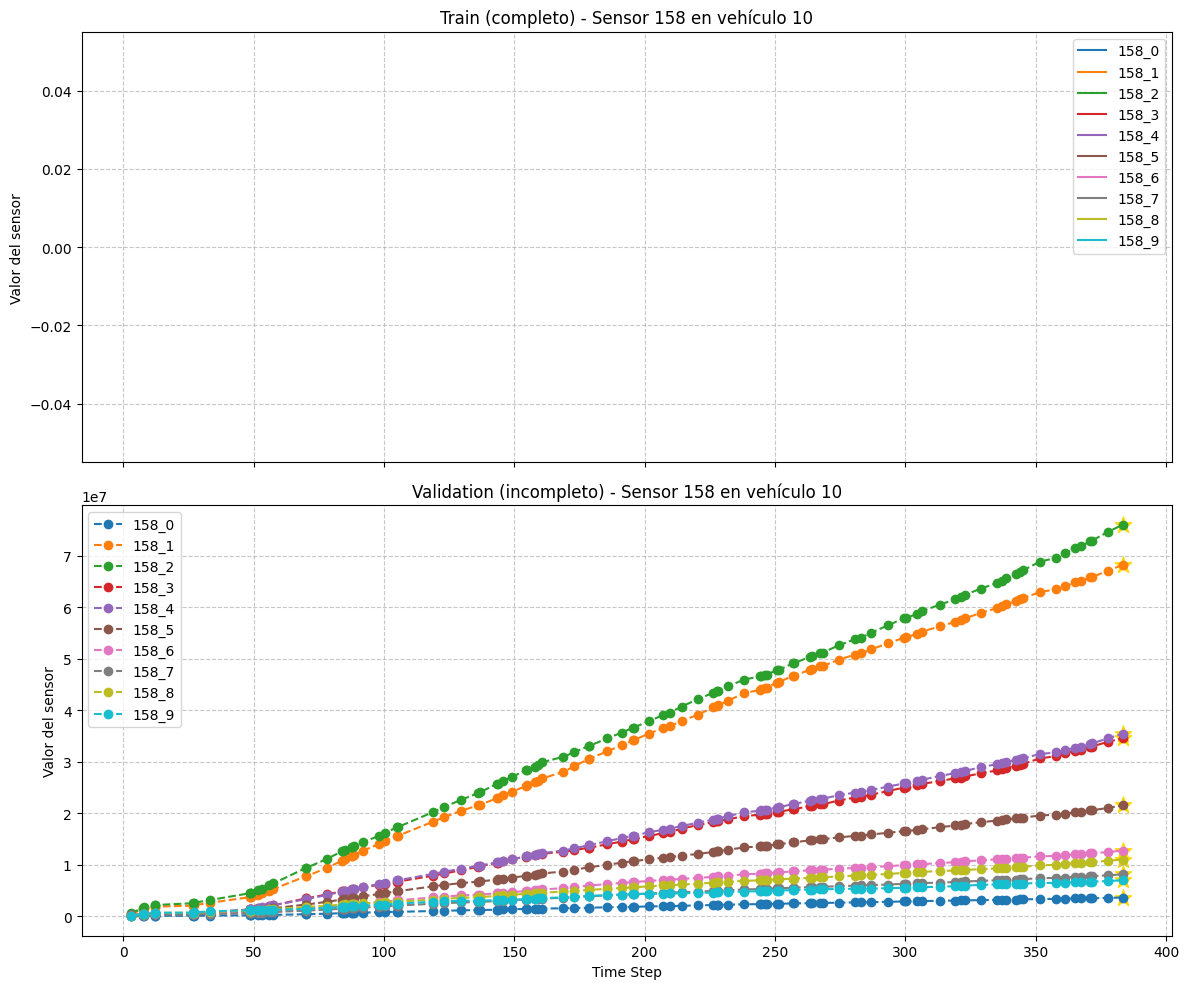

(0, 107)
(102, 107)


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Elegir vehículo y sensor base (sin el sufijo _0)
vehicle_id = 10
sensor_base = '158'   # sensor base, sin el "_0"

# Filtrar datos del vehículo en train y validation
train_data = train_operational_readouts[train_operational_readouts['vehicle_id'] == vehicle_id]
val_data = validation_operational_readouts[validation_operational_readouts['vehicle_id'] == vehicle_id]

# Seleccionar todas las columnas que empiezan con ese sensor (ej. 158_0, 158_1, 158_2...)
train_cols = [col for col in train_data.columns if col.startswith(sensor_base + "_")]
val_cols   = [col for col in val_data.columns if col.startswith(sensor_base + "_")]

# Graficar en dos subplots (train arriba, validation abajo)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Train completo ---
if train_cols:
    colors = sns.color_palette("tab10", len(train_cols))
    for col, color in zip(train_cols, colors):
        axes[0].plot(train_data['time_step'], train_data[col], label=col, color=color)
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'Sin datos en TRAIN', ha='center', va='center', fontsize=12)

axes[0].set_title(f'Train (completo) - Sensor {sensor_base} en vehículo {vehicle_id}')
axes[0].set_ylabel('Valor del sensor')
axes[0].grid(True, linestyle='--', alpha=0.7)

# --- Validation incompleto ---
if val_cols:
    colors = sns.color_palette("tab10", len(val_cols))
    for col, color in zip(val_cols, colors):
        axes[1].plot(val_data['time_step'], val_data[col], linestyle='--', marker='o', label=col, color=color)
        # marcar último punto de cada bin
        axes[1].scatter(val_data['time_step'].max(), val_data[col].iloc[-1],
                        color='gold', marker='*', s=150)
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Sin datos en VALIDATION', ha='center', va='center', fontsize=12)

axes[1].set_title(f'Validation (incompleto) - Sensor {sensor_base} en vehículo {vehicle_id}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Valor del sensor')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(train_data.shape)
print(val_data.shape)


Claro aqui nos damos cuenta que efectivamente la razon por la que no muestra nada la grafica de train es porque el vehiculo escogido no aparece en esa grafica. Vamos a validar si algun vehiculo aparece en ambas graficas.

In [39]:
# Obtener los IDs únicos de cada base
train_ids = set(train_operational_readouts['vehicle_id'].unique())
val_ids   = set(validation_operational_readouts['vehicle_id'].unique())

# Intersección: vehículos que aparecen en ambas
common_ids = train_ids.intersection(val_ids)

print("Vehículos presentes en ambas bases:", common_ids)
print("Cantidad de vehículos comunes:", len(common_ids))

Vehículos presentes en ambas bases: set()
Cantidad de vehículos comunes: 0


Ningun vehiculo aparecen en ambas graficas, esto indica que las bases de datos de train y validation son completamente disjuntas en términos de vehiculo. Aunque presenta la misma cantidad.

### Validation Labels

Esta base tambien contiene 5046 filas correspondientes al número de vehículos incluidos en los datos operacionales del conjunto de validación. En él se encuentra la columna class_label, que indica la clase asociada al último registro de cada vehículo. Dicho último registro se selecciona de manera aleatoria entre todos los disponibles y se clasifica en una de cinco categorías (0, 1, 2, 3, 4), según el intervalo temporal en que ocurre respecto a la falla: más de 48, entre 48 y 24, entre 24 y 12, entre 12 y 6, y entre 6 y 0 pasos de tiempo antes del fallo. Este diseño refleja distintos escenarios de observación parcial de los vehículos, aunque el conjunto está desbalanceado y presenta una mayor concentración en la clase 0.


In [3]:
# visualizar datos
validation_labels.head()

,vehicle_id,class_label
0,10,0
1,16,0
2,18,0
3,23,0
4,45,0


<Axes: xlabel='class_label'>

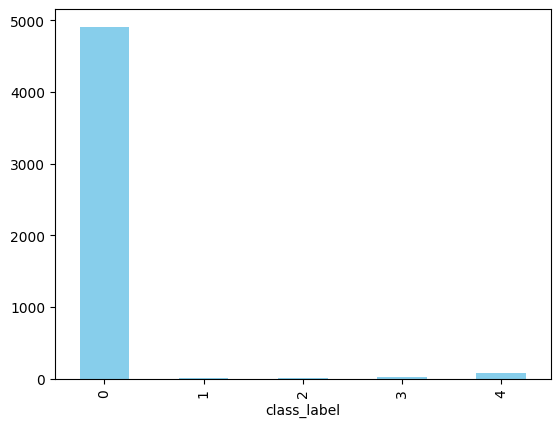

In [40]:
#vamos a ver la cantidad de readouts por cada clase
validation_labels['class_label'].value_counts().sort_index().plot(kind='bar', color='skyblue')

In [ ]:
# Esto representado en una tabla seria:
validation_labels['class_label'].value_counts().sort_index().reset_index().rename(columns={'index':'class_label', 'class_label':'count'})

,count,count
0,0,4910
1,1,16
2,2,14
3,3,30
4,4,76


In [50]:
# tiene valores nulos?
validation_labels.isnull().sum()

vehicle_id     0
class_label    0
dtype: int64

El conjunto de validación se visualiza aplicando dos técnicas de reducción de dimensionalidad: Análisis de Componentes Principales (PCA) y t-SNE. En ambos casos se toma el último registro de cada vehículo y se proyecta en un espacio bidimensional. Los vehículos de cada clase se representan con distintos colores, pero al observar los gráficos las cinco clases aparecen mezcladas sin una separación clara. Esto evidencia la complejidad del problema, ya que al reducir las características a dos dimensiones no se logra distinguir fácilmente entre las clases.


In [51]:
#vamos a hacer el PCA de la base de labels de validation
# sabiendo que solo tenemos:
""" vehicle_id     0
class_label    0 """

# es decir no hay nulos en esta base



' vehicle_id     0\nclass_label    0 '

### Validation Specifications

Tambien tiene una estructura identica a la de train_specifications.

In [5]:
# visualizar datos
validation_specifications.head()

,vehicle_id,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,10,Cat0,Cat0,Cat0,Cat0,Cat0,Cat1,Cat0,Cat1
1,16,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
2,18,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
3,23,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0
4,45,Cat0,Cat0,Cat0,Cat0,Cat0,Cat1,Cat0,Cat1


In [52]:
# no tiene valores nulos
validation_specifications.isnull().sum().sum()

np.int64(0)

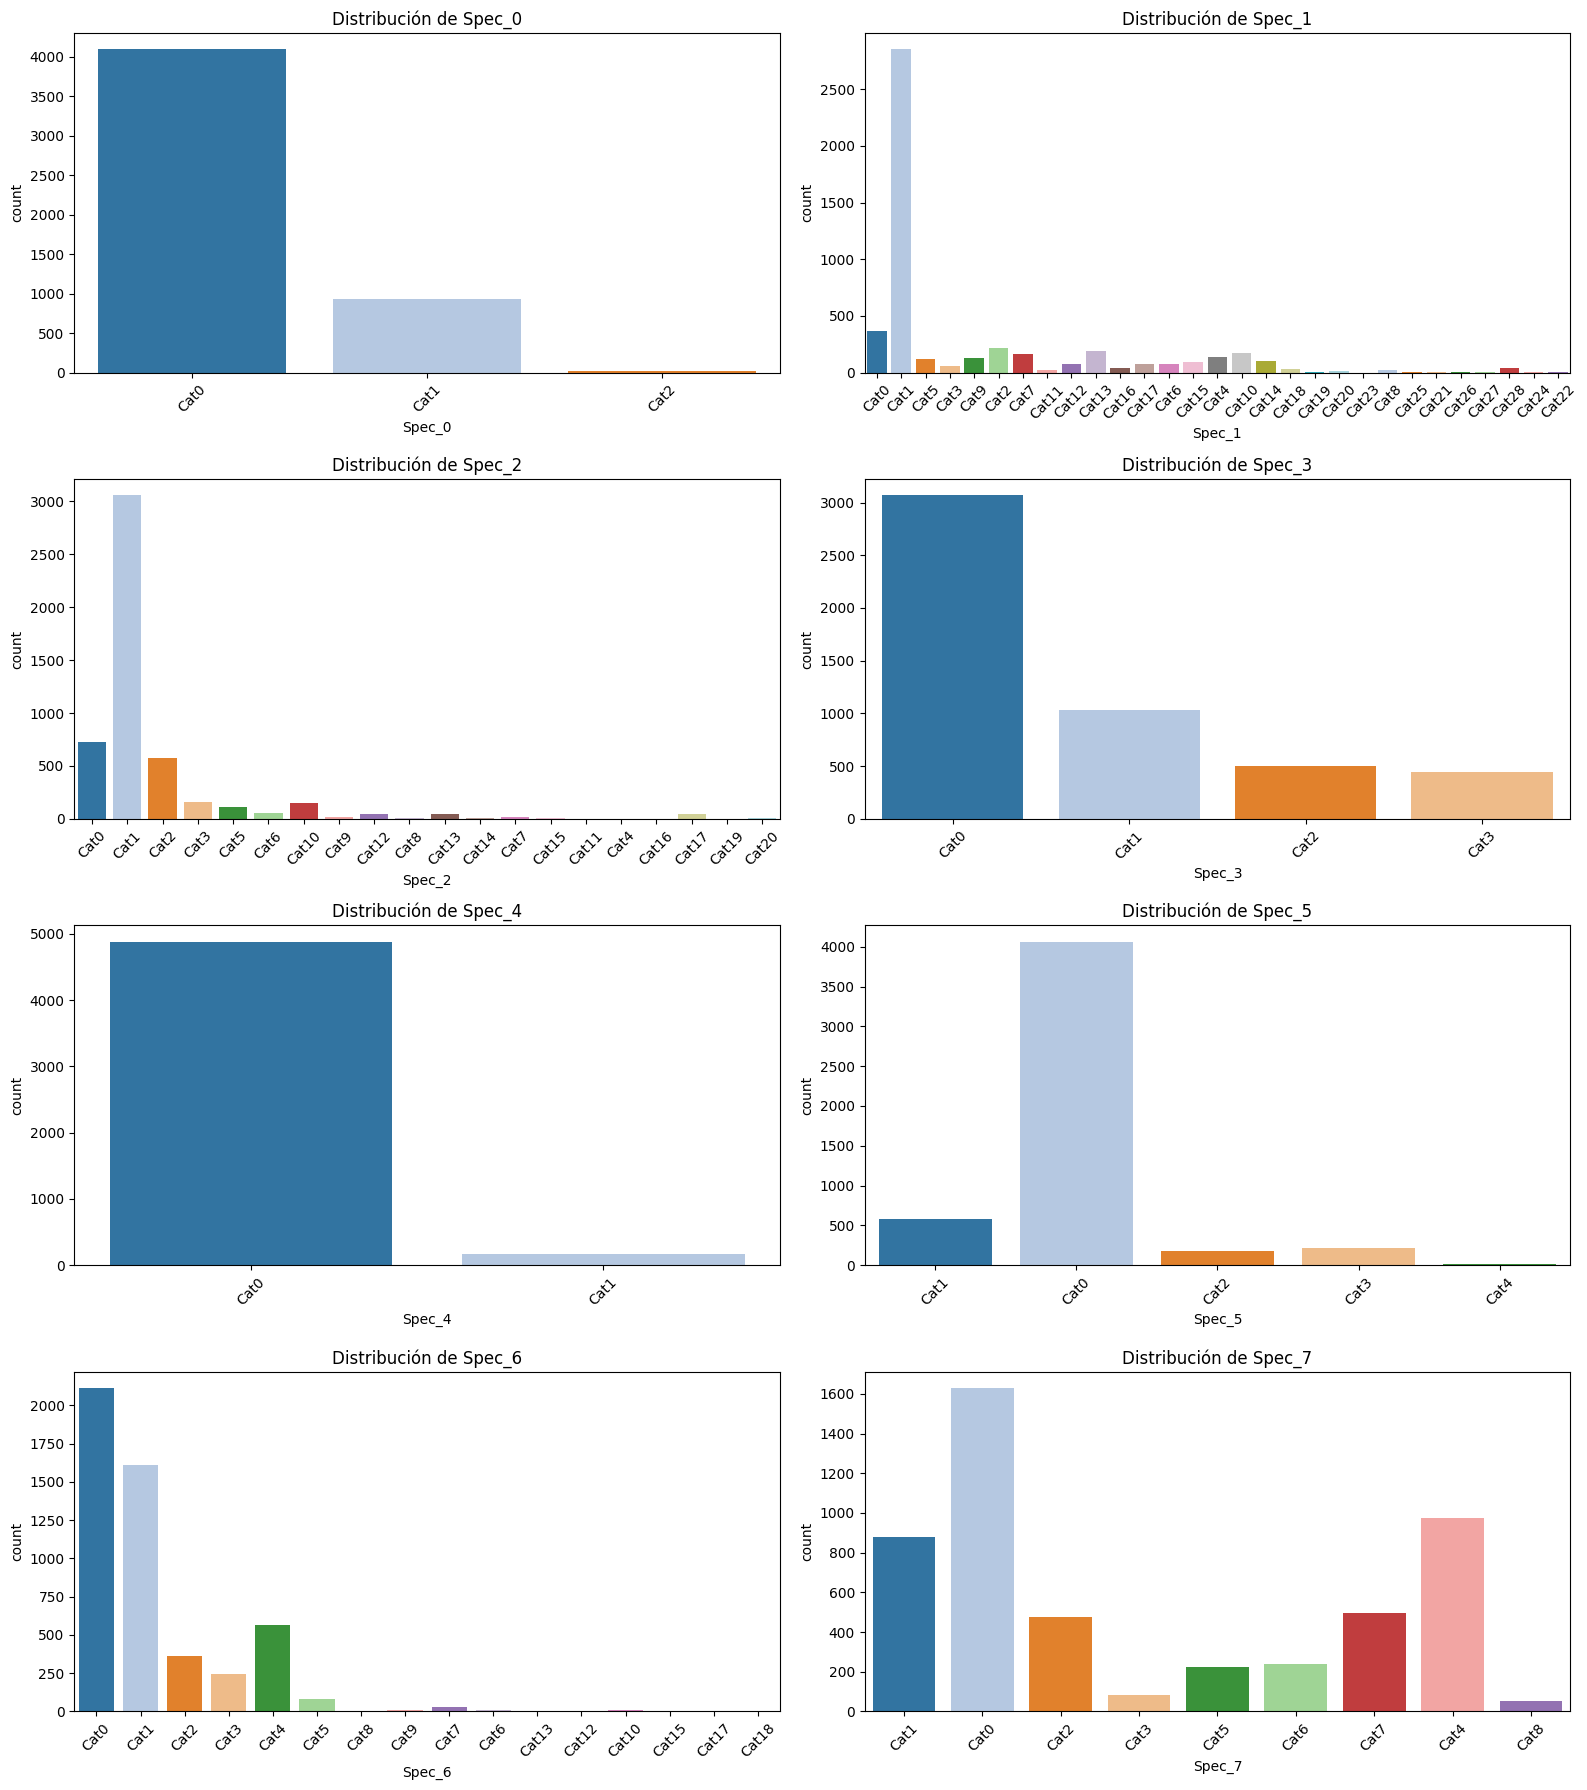

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar las columnas categóricas (excluyendo vehicle_id)
spec_cols = [col for col in validation_specifications.columns if col != 'vehicle_id']

# Crear figura con subplots (4 filas x 2 columnas)
fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

# Graficar cada columna
for i, col in enumerate(spec_cols):
    sns.countplot(
        data=validation_specifications,
        x=col,
        hue=col,                # <- necesario para usar palette sin warning
        palette="tab20",        # paleta de colores más amplia y sobria
        legend=False,           # ocultar leyenda redundante
        ax=axes[i]
    )
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Si sobran subplots, eliminarlos
if len(spec_cols) < len(axes):
    for j in range(len(spec_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
